# Investigating the effect of over-selection for large populations (when possible).
#### NP -> Large takes to much time to converge

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import pandas as pd
from IPython.display import display, HTML
import random
import warnings
import time
warnings.filterwarnings('ignore')  # Disable all warnings

In [2]:
def plot_progress(history, generations):
    plt.plot(range(len(history)), history, label='Cost')  # Make sure to plot based on history length
    plt.xlabel('Generation')
    plt.ylabel('Cost')
    plt.title('Evolutionary Process (Cost vs. Generation)')
    plt.legend()
    plt.show()


# 🔹 Activation functions
def relu(z):
    return np.maximum(0, z)

def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))  # For numerical stability
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

# 🔹 Create small random weights and biases.
def initialize_parameters(layer_dims):
    np.random.seed(1)
    parameters = {}
    for l in range(1, len(layer_dims)):
        parameters[f"W{l}"] = np.random.randn(layer_dims[l-1], layer_dims[l]) * 0.01
        parameters[f"b{l}"] = np.zeros((1, layer_dims[l]))
    return parameters

# 🔹 Flatten and Unflatten parameters (because our de accept only 1d vector)
def flatten_parameters(parameters):
    flat_list = []
    for l in range(1, len(parameters)//2 + 1):
        flat_list.append(parameters[f"W{l}"].flatten())
        flat_list.append(parameters[f"b{l}"].flatten())
    return np.concatenate(flat_list)

def unflatten_parameters(vector, layer_dims):
    '''parameters = {
    "W1": (64x32 array),
    "b1": (1x32 array),
    "W2": (32x10 array),
    "b2": (1x10 array)
}'''
    # parameters -> dict of weights and baises
    parameters = {}
    start = 0
    for l in range(1, len(layer_dims)):
        w_size = layer_dims[l-1] * layer_dims[l]
        b_size = layer_dims[l]
        
        parameters[f"W{l}"] = vector[start:start + w_size].reshape(layer_dims[l-1], layer_dims[l])
        start += w_size
        parameters[f"b{l}"] = vector[start:start + b_size].reshape(1, layer_dims[l])
        start += b_size
    return parameters

# 🔹 Forward propagation(relu for hidden layers // softmax for output layer)
def forward_propagation(X, parameters):
    A = X
    L = len(parameters) // 2

    for l in range(1, L):
        Z = A.dot(parameters[f"W{l}"]) + parameters[f"b{l}"]
        A = relu(Z)

    # Output layer (softmax)
    Z = A.dot(parameters[f"W{L}"]) + parameters[f"b{L}"]
    A = softmax(Z)

    return A

# 🔹 Cost function (cross-entropy)
def compute_cost(y_hat, y):
    m = y.shape[0]
    cost = -np.sum(y * np.log(y_hat + 1e-8)) / m
    return cost

# 🔹 Prediction
def predict(X, parameters):
    y_hat = forward_propagation(X, parameters)
    return np.argmax(y_hat, axis=1)

# 🔹 Fitness function for DE
def fitness(vector, X, y, layers):
    parameters = unflatten_parameters(vector, layers)
    y_hat = forward_propagation(X, parameters)
    return compute_cost(y_hat, y)

# 🔹 Differential Evolution
def differential_evolution(fitness_func, bounds, args=(), NP=10, F=0.4, CR=0.9, generations=500,plot_interval=100):
    dim = len(bounds)
    pop = np.random.rand(NP, dim) #between 0 and 1
    min_b, max_b = np.asarray(bounds).T
    diff = np.fabs(min_b - max_b) #fabs -> absolute but return float numbers
    pop_denorm = min_b + pop * diff #between -1 and 1
    fitness = np.asarray([fitness_func(ind, *args) for ind in pop_denorm])
    best_idx = np.argmin(fitness) #best fitness
    best = pop_denorm[best_idx] # best parameters
    history = []

    for gen in range(generations):
        for i in range(NP):
            # it is used to pick 3 random individual without replacement
            idxs = [idx for idx in range(NP) if idx != i]  # list of all indices from 0 to NP - 1
            # randomly selects 3 different individuals(without repetition)
            a, b, c = pop[np.random.choice(idxs, 3, replace=False)]
            # np.clip() -> (array, min_value, max_value)
            mutant = np.clip(a + F * (b - c), 0, 1)
            cross_points = np.random.rand(dim) < CR
            #Ensure at least one happen
            if not np.any(cross_points):
                cross_points[np.random.randint(0, dim)] = True
            # to give us our real shape to pass it to fitness func
            # True -> mutant // False ->pop[i]
            trial = np.where(cross_points, mutant, pop[i])
            trial_denorm = min_b + trial * diff
            f = fitness_func(trial_denorm, *args)
            if f < fitness[i]:
                fitness[i] = f
                pop[i] = trial
                if f < fitness[best_idx]:
                    best_idx = i
                    best = trial_denorm
        history.append(fitness[best_idx])

        if gen % plot_interval == 0 and gen != 0:  
            print(f"Generation {gen}, Cost: {fitness[best_idx]:.4f}")
            plot_progress(history, generations)

    return best, history


In [3]:
def plot_ex(X_test,y_pred):
    plt.figure(figsize=(12, 6))
    for i in range(10):
        idx = random.randint(0, len(X_test)-1)
        image = X_test[idx].reshape(8,8)
        plt.subplot(2,5,i+1)
        plt.imshow(image, cmap='gray')
        plt.title(f"Pred: {y_pred[idx]}")
        plt.axis('off')

def loss_curve(x,model_name,steps):
    plt.figure(figsize=(12, 6))
    plt.plot(x, 'b-', linewidth=2)
    plt.title(f"Loss Curve During {model_name} Optimization", fontsize=14)
    plt.xlabel(steps, fontsize=12)
    plt.ylabel("Cross-Entropy Loss", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

def plot_cm(model_name,y_true,y_pred):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues")
    plt.title(f"Confusion Matrix For {model_name}")
    plt.show()

def class_report(model_name, y_true, y_pred,color='Blues'):
    report_dict = classification_report(y_true, y_pred, output_dict=True)
    df = pd.DataFrame(report_dict).transpose()
    
    df = df.round(2)

    display(HTML(f"<h3>Classification Report for <span style='color:steelblue'>{model_name}</span></h3>"))

    styled_df = df.style.background_gradient(cmap=color, axis=0)\
                        .set_table_styles([{
                            'selector': 'th',
                            'props': [('background-color', '#f0f0f0'),
                                      ('font-weight', 'bold')]
                        }])\
                        .format(precision=2)

    display(styled_df)

def plot_misclassified(X_test, y_true, y_pred,model_name):
    misclassified = np.where(y_true != y_pred)[0]
    plt.figure(figsize=(12, 6))
    plt.suptitle(f"Misclassified - {model_name}", fontsize=16)
    for i, idx in enumerate(np.random.choice(misclassified, size=10, replace=False)):
        image = X_test[idx].reshape(8, 8)
        plt.subplot(2, 5, i + 1)
        plt.imshow(image, cmap='gray')
        plt.title(f"True: {y_true[idx]}\nPred: {y_pred[idx]}")
        plt.axis('off')

def plot_multiclass_roc(y_true, y_score, n_classes, model_name):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        
    plt.figure(figsize=(10, 8))
    colors = plt.cm.get_cmap('tab10')(range(n_classes))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
                 label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([-0.01, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Multiclass ROC Curve - {model_name}')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()



Generation 100, Cost: 1.7985


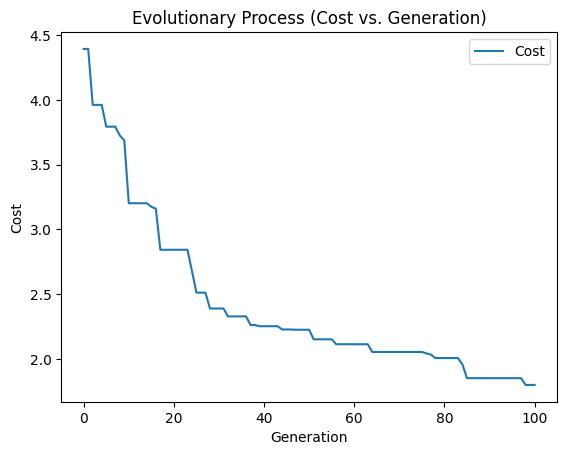

Generation 200, Cost: 1.2281


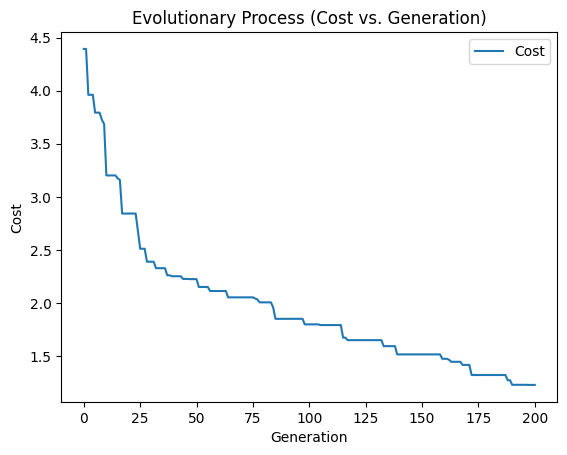

Generation 300, Cost: 0.8074


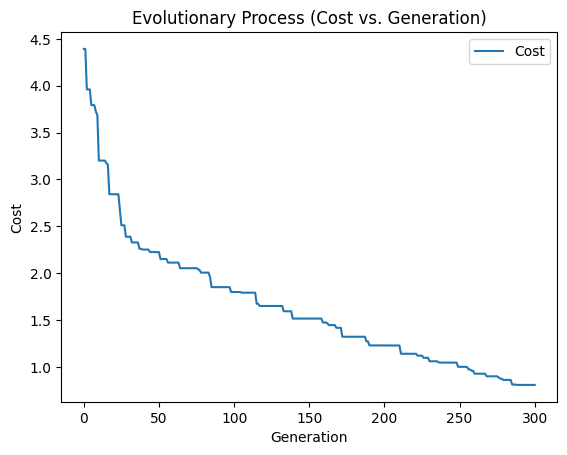

Generation 400, Cost: 0.5236


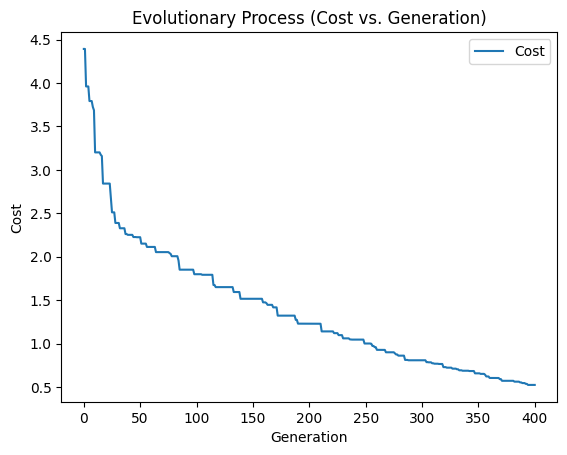

Generation 500, Cost: 0.3546


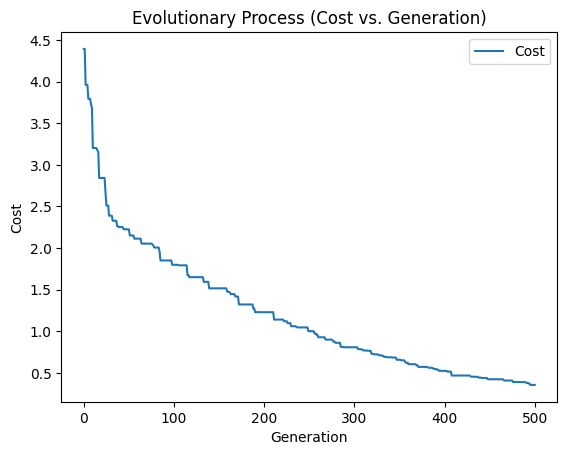

Generation 600, Cost: 0.2592


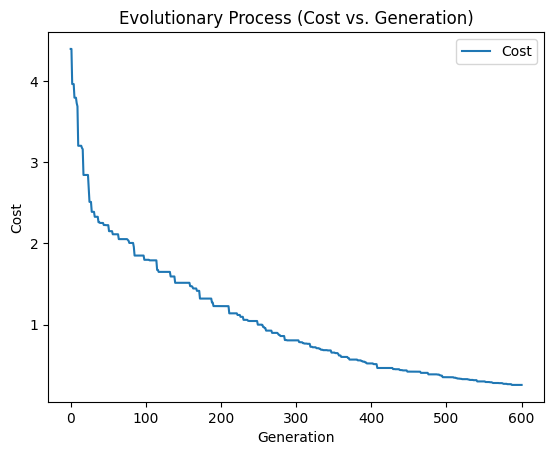

Generation 700, Cost: 0.1971


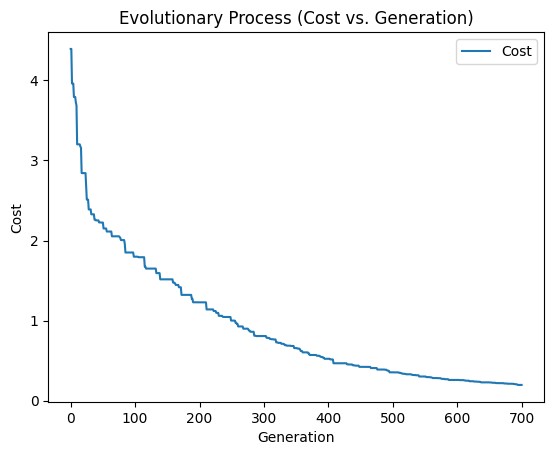

Generation 800, Cost: 0.1505


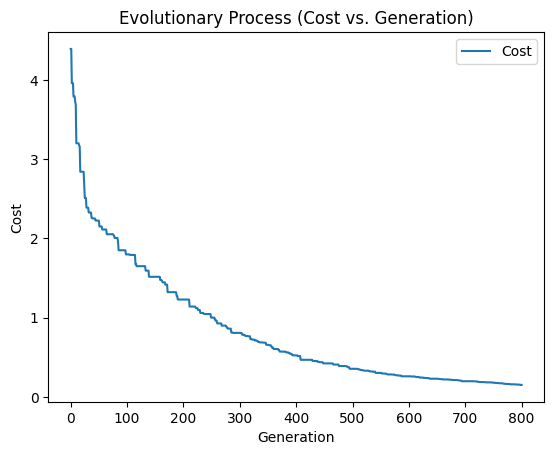

Generation 900, Cost: 0.1260


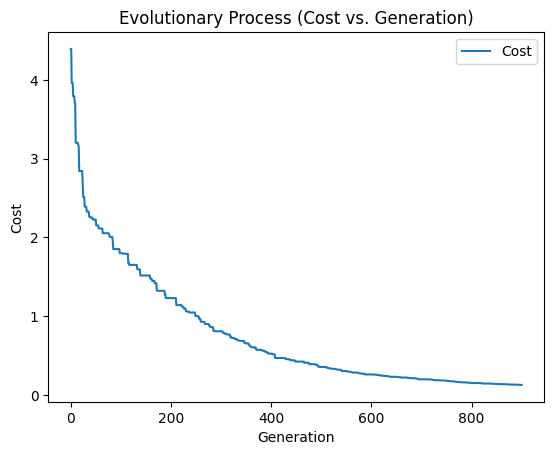

Generation 1000, Cost: 0.1047


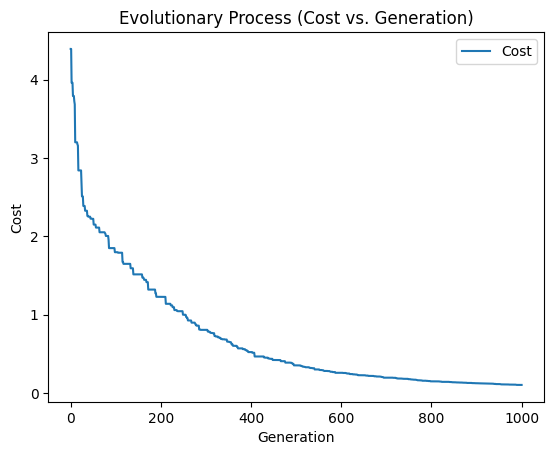

Generation 1100, Cost: 0.0863


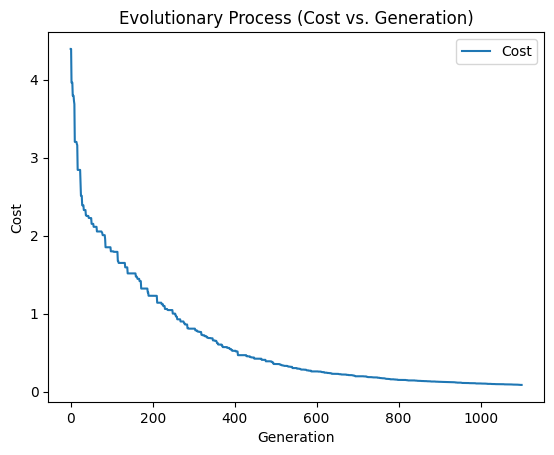

Generation 1200, Cost: 0.0751


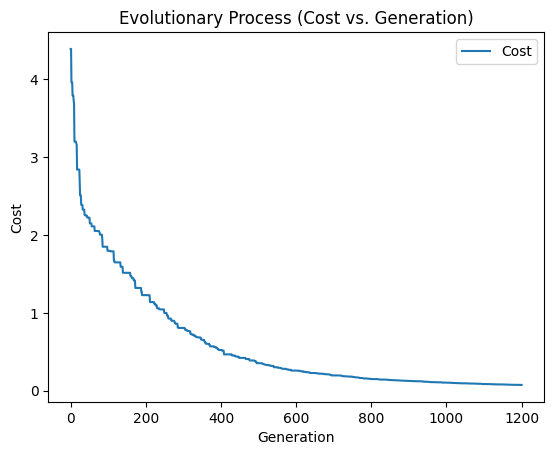

Test Accuracy with DE: 94.72%


In [4]:
# 🔹 Load MNIST-like Digits dataset
digits = load_digits()
X = digits.data / 16.0  # Normalize (pixel values between 0 and 1)
y = digits.target

# One-hot encode labels
encoder = OneHotEncoder(sparse_output=False)
y_encoded = encoder.fit_transform(y.reshape(-1, 1))

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# 🔹 Neural Network structure
layers = [64, 32, 10]  # 64 inputs → 32 hidden → 10 outputs

# Prepare bounds
params = initialize_parameters(layers)
flat_params = flatten_parameters(params)
bounds = [(-1, 1)] * len(flat_params)

# 🔹 Run DE
start_time = time.time()
best_vector, history = differential_evolution(fitness, bounds, args=(X_train, y_train, layers),NP=100,F=0.4 ,CR=0.9, generations=1250,plot_interval=100)
de_time = time.time() - start_time
# Rebuild best parameters
best_params = unflatten_parameters(best_vector, layers)

# 🔹 Evaluate
y_pred = predict(X_test, best_params)
y_true = np.argmax(y_test, axis=1)
de_accuracy = np.mean(y_pred == y_true)
print(f"Test Accuracy with DE: {de_accuracy * 100:.2f}%")


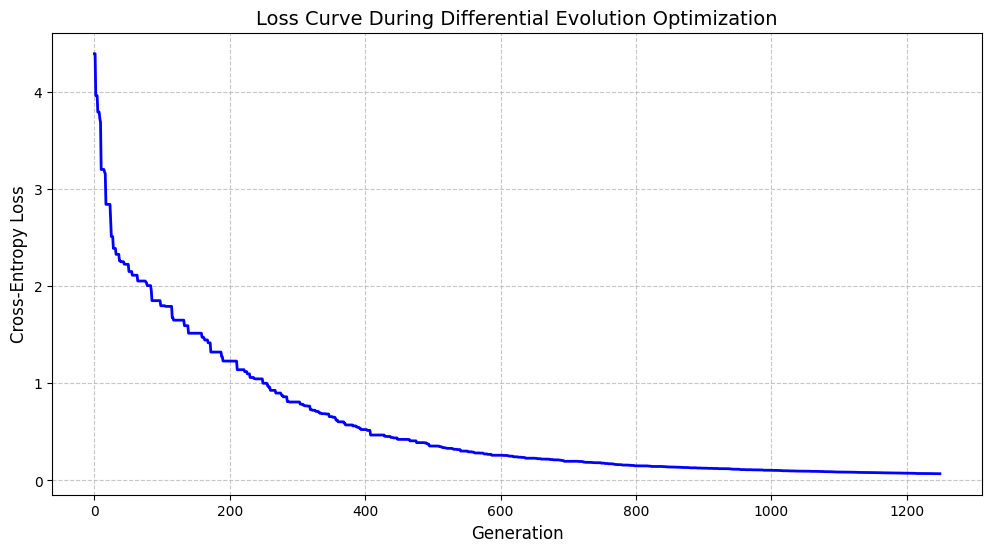

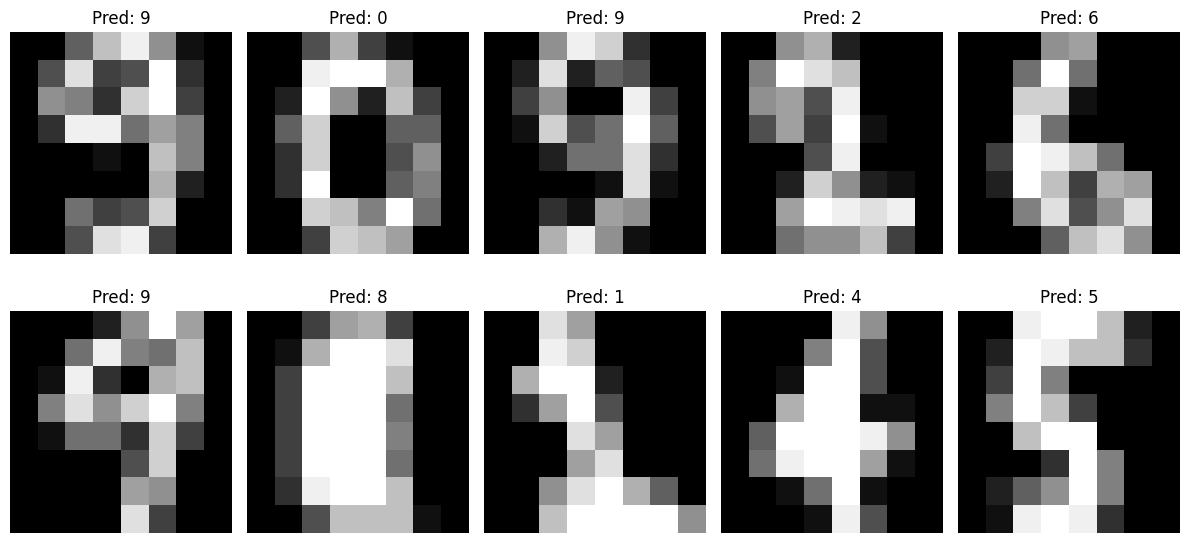

In [5]:
# 🔹 Plot learning curve
loss_curve(history,'Differential Evolution','Generation')

# 🔹 Visualize some predictions
plot_ex(X_test,y_pred)

plt.tight_layout()
plt.show()

Accuracy: 95.83


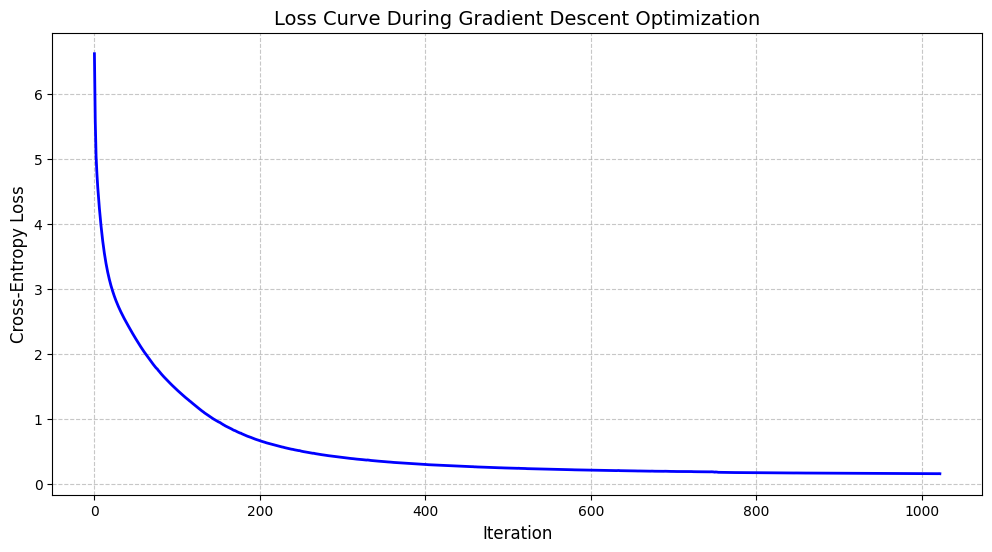

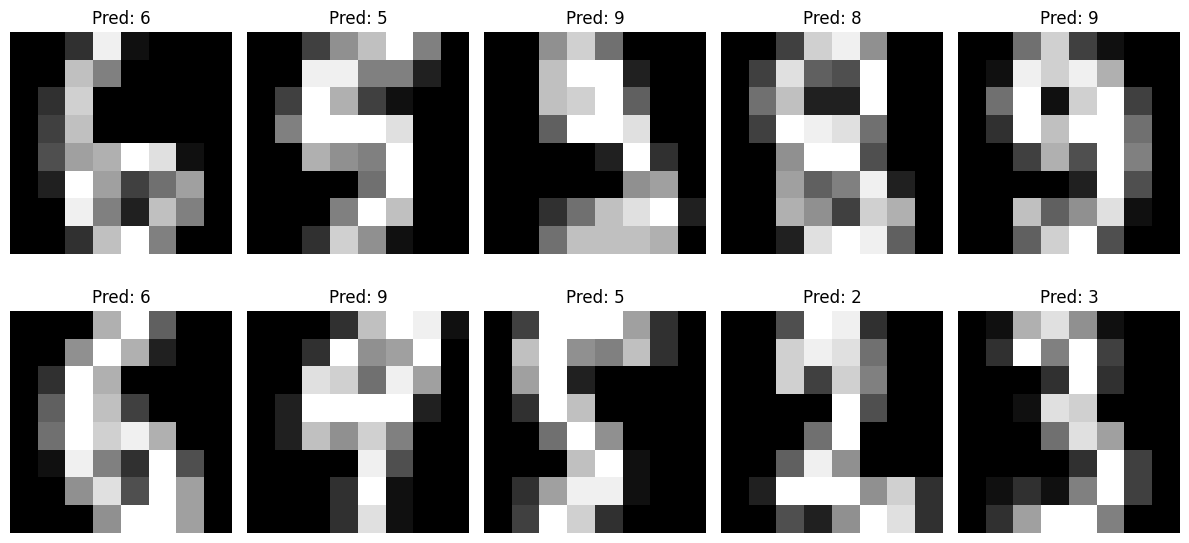

In [6]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

start_time = time.time()
mlp = MLPClassifier(hidden_layer_sizes=(64,32,10,),
                    activation='tanh', 
                    alpha = 0.1,
                    solver='adam',             
                    max_iter=1500, 
                    random_state=42)

mlp.fit(X_train, y_train)
mlp_time = time.time() - start_time
y_pred_mlp = mlp.predict(X_test)
y_pred_digits = np.argmax(y_pred_mlp, axis=1)
mlp_accuracy = accuracy_score(y_test, y_pred_mlp)
print(f"Accuracy: {mlp_accuracy*100:.2f}")

# 🔹 Plot learning curve
loss_curve(mlp.loss_curve_,'Gradient Descent','Iteration')

# 🔹 Visualize some predictions
plot_ex(X_test,y_pred_digits)

plt.tight_layout()
plt.show()

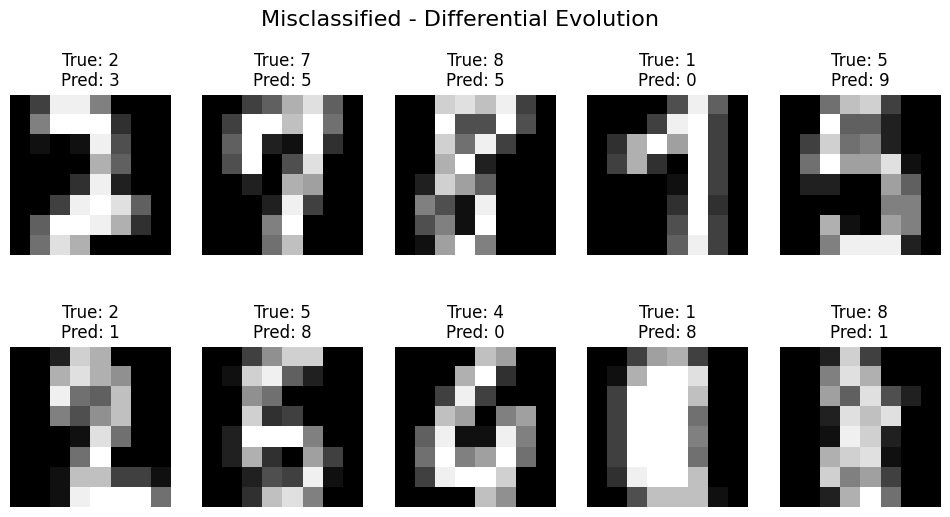

In [7]:
plot_misclassified(X_test,y_true,y_pred,'Differential Evolution')

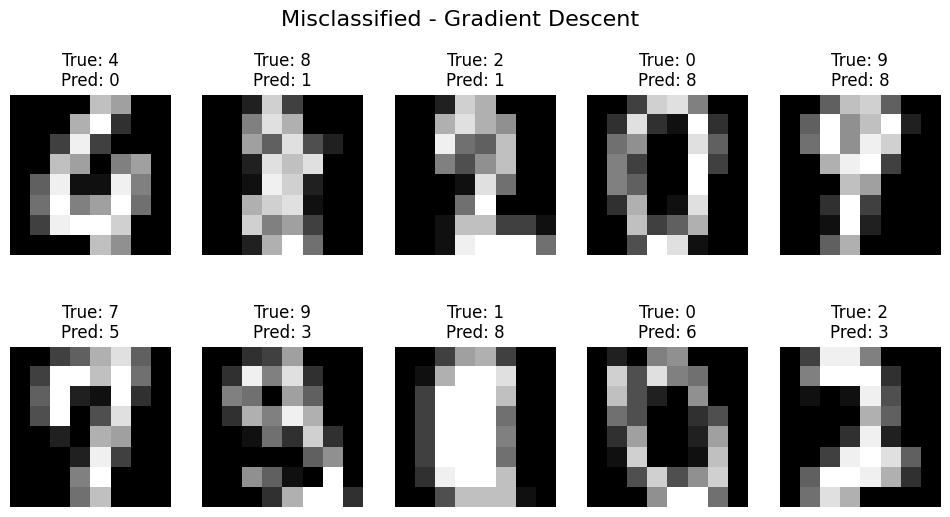

In [8]:
plot_misclassified(X_test,y_true,y_pred,'Gradient Descent')

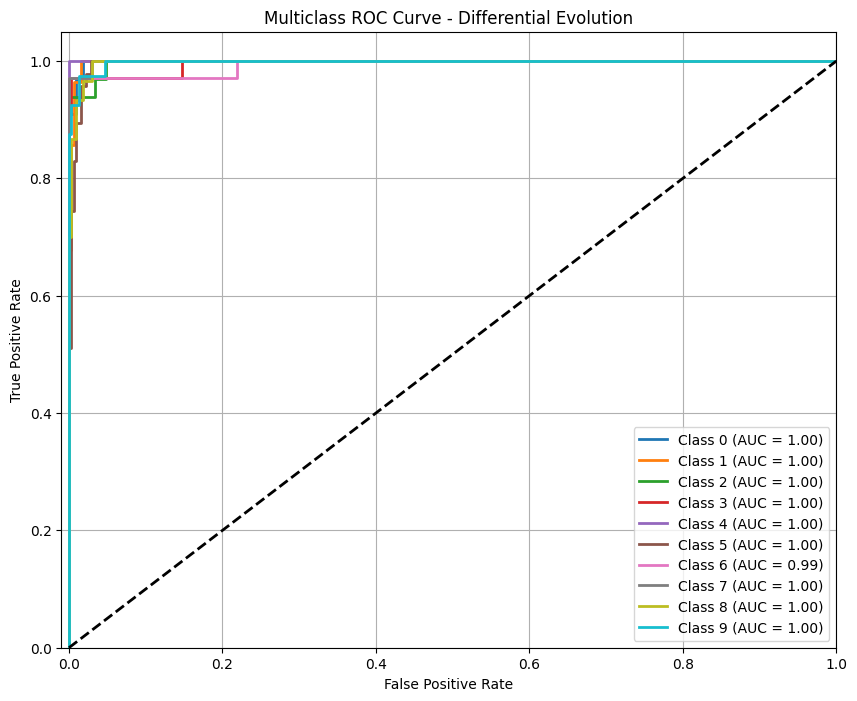

In [11]:
plot_multiclass_roc(y_test, forward_propagation(X_test, best_params), 10, 'Differential Evolution')

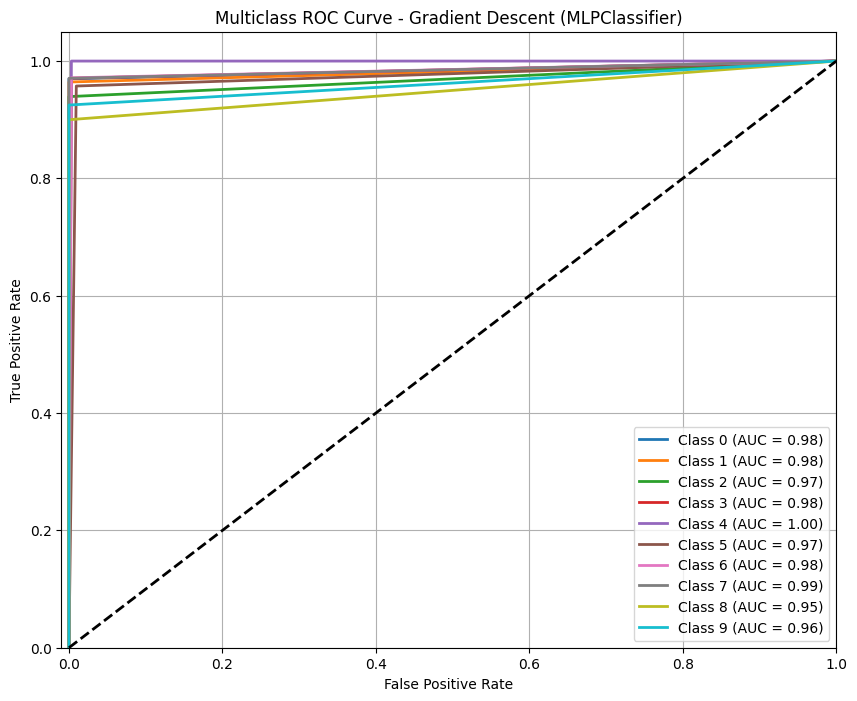

In [12]:
plot_multiclass_roc(y_test, y_pred_mlp, 10, 'Gradient Descent (MLPClassifier)')

In [13]:
print(f"MLPClassifier: Time={mlp_time:.2f}s")
print(f"DE-NN: Time={de_time:.2f}s")
print(f"Test Accuracy with DE: {de_accuracy * 100:.2f}%")
print(f"Test Accuracy with MLP: {mlp_accuracy*100:.2f}")

MLPClassifier: Time=24.20s
DE-NN: Time=271.70s
Test Accuracy with DE: 94.72%
Test Accuracy with MLP: 95.83


# Classification Metrics Explained

---

### **<span style="color: #ff6347;">Macro Avg</span>**
**The unweighted average across all classes, treating all classes equally.**

---

### **<span style="color: #1e90ff;">Weighted Avg</span>**
**The average across all classes, weighted by the number of instances in each class.**

---

### **<span style="color: #32cd32;">Precision (Classifier)</span>**
**Measures how many of the predicted positive samples were correct.**

---

### **<span style="color: #ffa500;">Recall (Object)</span>**
**Measures how many of the actual positive samples were correctly identified.**

---

### **<span style="color: #9400d3;">F1-Score</span>**
**The harmonic mean of precision and recall. It balances the two metrics.**

---

### **<span style="color: #ff4500;">Support</span>**
**The number of true instances of each class in the dataset.**



In [14]:
class_report('DE',y_true,y_pred,'Blues')

,precision,recall,f1-score,support
0,0.91,0.91,0.91,33.00
1,0.93,0.93,0.93,28.00
2,1.00,0.94,0.97,33.00
3,0.94,0.97,0.96,34.00
4,1.00,0.98,0.99,46.00
5,0.88,0.96,0.92,47.00
6,0.97,0.97,0.97,35.00
7,1.00,0.97,0.99,34.00
8,0.88,0.93,0.90,30.00
9,0.97,0.90,0.94,40.00


In [15]:
class_report('MLP',y_true,y_pred_digits,'Blues')

,precision,recall,f1-score,support
0,0.78,0.97,0.86,33.00
1,1.00,0.96,0.98,28.00
2,1.00,0.94,0.97,33.00
3,0.97,0.97,0.97,34.00
4,0.98,1.00,0.99,46.00
5,0.94,0.96,0.95,47.00
6,0.97,0.97,0.97,35.00
7,1.00,0.97,0.99,34.00
8,1.00,0.90,0.95,30.00
9,1.00,0.92,0.96,40.00


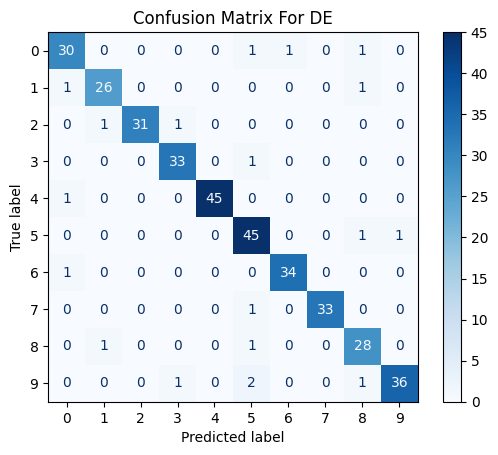

In [16]:
plot_cm('DE',y_true,y_pred)

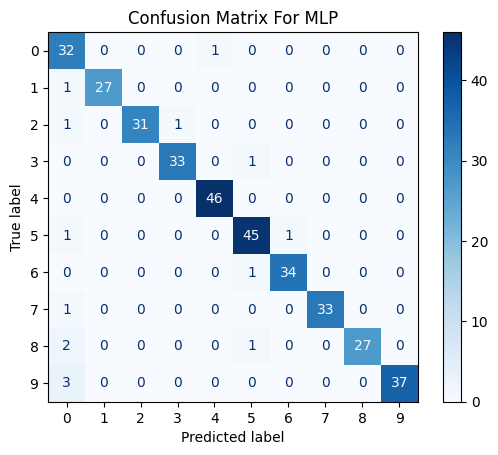

In [17]:
plot_cm('MLP',y_true,y_pred_digits)

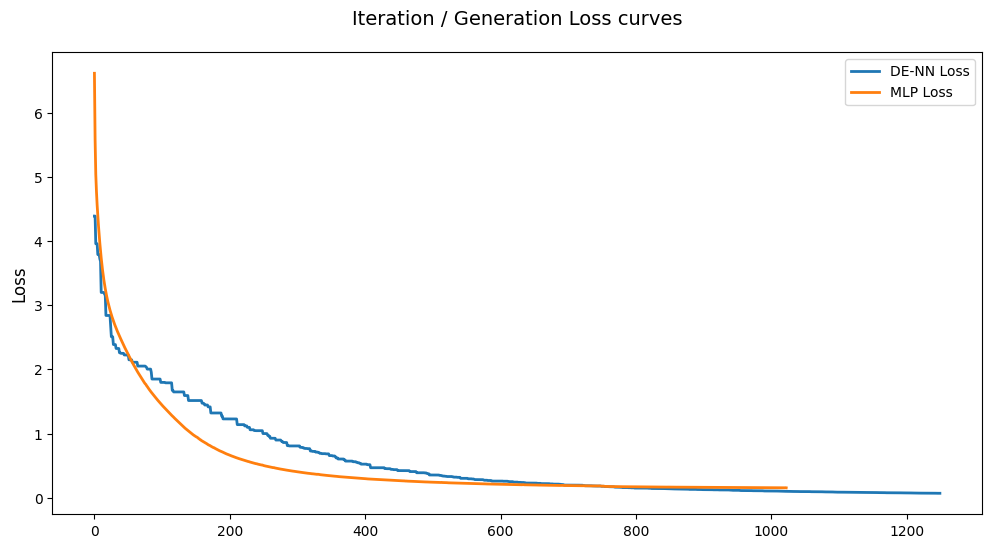

In [18]:
plt.figure(figsize=(12, 6))
plt.plot(history, label='DE-NN Loss', color='#1f77b4', linewidth=2)
plt.plot(mlp.loss_curve_, label='MLP Loss', color='#ff7f0e',linewidth=2)
plt.title('Iteration / Generation Loss curves',fontsize=14, pad=20)
plt.ylabel('Loss',fontsize=12)
plt.legend()
plt.show()

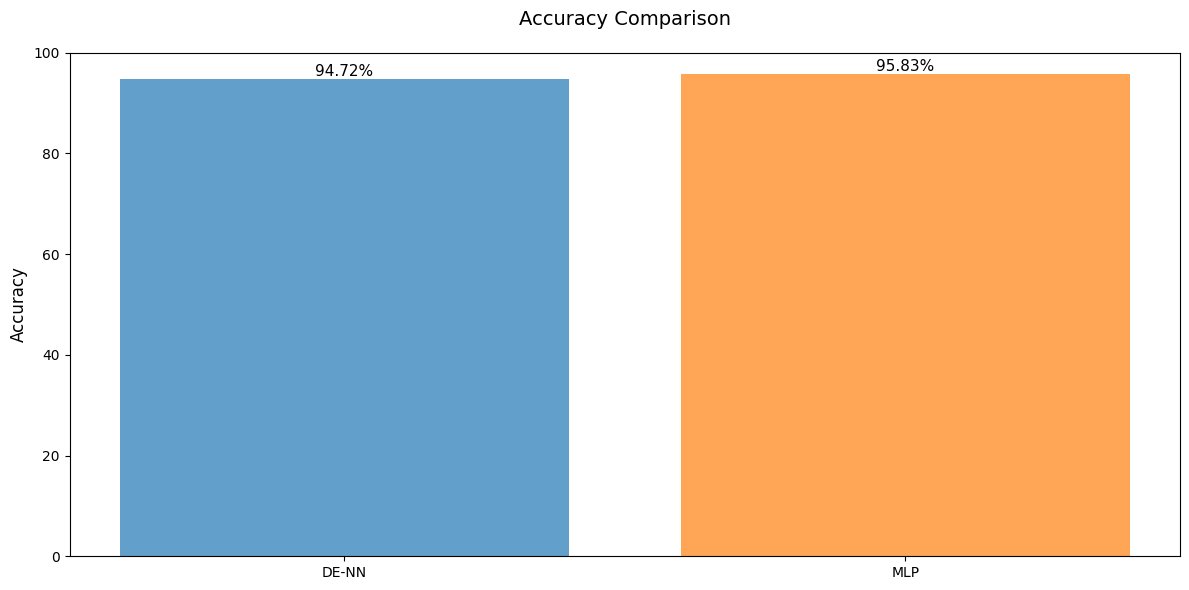

In [19]:
plt.figure(figsize=(12, 6))

models = ['DE-NN', 'MLP']
accuracies = [de_accuracy*100, mlp_accuracy*100]
colors = ['#1f77b4', '#ff7f0e']

bars = plt.bar(models, accuracies, color=colors, alpha=0.7)

plt.title('Accuracy Comparison', fontsize=14, pad=20)
plt.ylabel('Accuracy', fontsize=12)
plt.ylim(0, 100)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, 
             f'{height:.2f}%', 
             ha='center', va='bottom', fontsize=11)

plt.tight_layout()
plt.show()

<table style="width:100%; border-collapse: collapse; font-family: Arial, sans-serif;">
  <thead style="background-color: #f2f2f2;">
    <tr>
      <th style="border: 1px solid #ccc; padding: 8px;">Aspect</th>
      <th style="border: 1px solid #ccc; padding: 8px;">DE-NN (Differential Evolution)</th>
      <th style="border: 1px solid #ccc; padding: 8px;">MLPClassifier (Gradient-based)</th>
      <th style="border: 1px solid #ccc; padding: 8px;">Which is Better?</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td style="border: 1px solid #ccc; padding: 8px;">Accuracy</td>
      <td style="border: 1px solid #ccc; padding: 8px;">94.72%</td>
      <td style="border: 1px solid #ccc; padding: 8px;">95.83%</td>
      <td style="border: 1px solid #ccc; padding: 8px;"><b>MLP</b></td>
    </tr>
    <tr>
      <td style="border: 1px solid #ccc; padding: 8px;">Macro F1-score</td>
      <td style="border: 1px solid #ccc; padding: 8px;">0.95</td>
      <td style="border: 1px solid #ccc; padding: 8px;">0.96</td>
      <td style="border: 1px solid #ccc; padding: 8px;"><b>MLP</b></td>
    </tr>
    <tr>
      <td style="border: 1px solid #ccc; padding: 8px;">Weighted F1-score</td>
      <td style="border: 1px solid #ccc; padding: 8px;">0.95</td>
      <td style="border: 1px solid #ccc; padding: 8px;">0.96</td>
      <td style="border: 1px solid #ccc; padding: 8px;"><b>MLP</b></td>
    </tr>
    <tr>
      <td style="border: 1px solid #ccc; padding: 8px;">Training Time</td>
      <td style="border: 1px solid #ccc; padding: 8px;">271.70 seconds</td>
      <td style="border: 1px solid #ccc; padding: 8px;">24.20 seconds</td>
      <td style="border: 1px solid #ccc; padding: 8px;"><b>MLP</b></td>
    </tr>
    <tr>
      <td style="border: 1px solid #ccc; padding: 8px;">Loss Curve</td>
      <td style="border: 1px solid #ccc; padding: 8px;">Stepped, slow convergence</td>
      <td style="border: 1px solid #ccc; padding: 8px;">Smooth, fast convergence</td>
      <td style="border: 1px solid #ccc; padding: 8px;"><b>MLP</b></td>
    </tr>
    <tr>
      <td style="border: 1px solid #ccc; padding: 8px;">Optimization Method</td>
      <td style="border: 1px solid #ccc; padding: 8px;">Evolutionary (Population-based)</td>
      <td style="border: 1px solid #ccc; padding: 8px;">Gradient-based (Backpropagation)</td>
      <td style="border: 1px solid #ccc; padding: 8px;">Depends on task</td>
    </tr>
    <tr style="background-color: #e8f4e5;">
      <td style="border: 1px solid #ccc; padding: 8px;"><b>Overall Verdict</b></td>
      <td colspan="3" style="border: 1px solid #ccc; padding: 8px;"><b>MLPClassifier is better</b> for this classification task due to higher accuracy, faster training time, and smoother convergence. DE-NN is still useful when gradients are unavailable or you need black-box optimization.</td>
    </tr>
  </tbody>
</table>
ptimization.</td>
    </tr>
  </tbody>
</table>
